In [1]:
import os
import open3d
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
device = 'cuda:0'
version = "v1"
backbone = "ViTL14"
root = '/home/user/UniDepth' # TODO: change this to your own path


In [3]:
rgb_path = os.path.join(root, 'assets/demo/rgb.png')
rgb = np.array(Image.open(rgb_path))

# intrinsics
intrinsics_gt = np.load(os.path.join(root, 'assets/demo/intrinsics.npy'))

# resolution
width = int(rgb.shape[1])
height = int(rgb.shape[0])

depth_path = os.path.join(root, 'assets/demo/depth.png')
depth_gt = np.array(Image.open(depth_path))
depth_gt = depth_gt.astype(np.float32) / 1000.0 # uint16 to meters


In [4]:
# Open3D rgbd image
o3d_color = open3d.geometry.Image(rgb)
o3d_depth = open3d.geometry.Image(depth_gt)
o3d_rgbd = open3d.geometry.RGBDImage.create_from_color_and_depth(
    color=o3d_color,
    depth=o3d_depth,
    depth_scale=1.0,
    depth_trunc=10.0,
    convert_rgb_to_intensity=False
)
# open3d.visualization.draw_geometries([o3d_rgbd])

# point cloud
pcd_gt = open3d.geometry.PointCloud.create_from_rgbd_image(
    image=o3d_rgbd,
    intrinsic=open3d.camera.PinholeCameraIntrinsic(width=width, height=height, intrinsic_matrix=intrinsics_gt),
    project_valid_depth_only=True
)

# open3d.visualization.draw_geometries([pcd_gt])


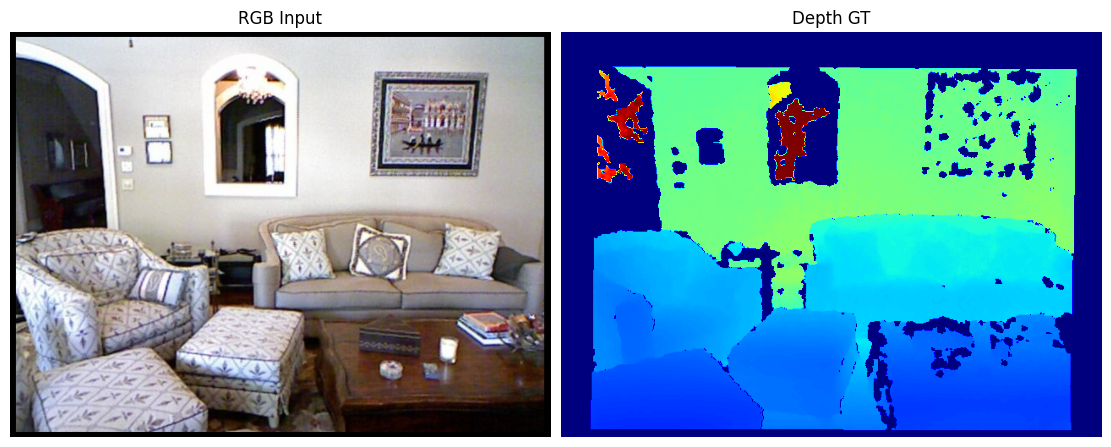

In [5]:
# visualize input
fig, axs = plt.subplot_mosaic(
    [['RGB', 'Depth_GT']], figsize=(11, 11), layout='constrained')

plt_img1 = axs['RGB'].imshow(rgb)
axs['RGB'].set_axis_off()
axs['RGB'].set_title('RGB Input')

plt_img2 = axs['Depth_GT'].imshow(depth_gt, vmin=0, vmax=10, cmap='jet')
axs['Depth_GT'].set_axis_off()
axs['Depth_GT'].set_title('Depth GT')

plt.show()


In [6]:
model = torch.hub.load("lpiccinelli-eth/UniDepth", "UniDepth",
                       version=version, backbone=backbone,
                       pretrained=True, trust_repo=True,
                       force_reload=True)
model = model.to(device)


Downloading: "https://github.com/lpiccinelli-eth/UniDepth/zipball/main" to /home/user/.cache/torch/hub/main.zip


Instantiate: dinov2_vitl14
UniDepth_v1_ViTL14 is loaded with:
	missing keys: ['pixel_encoder.register_tokens']
	additional keys: []


In [12]:
# predict
rgb_torch = torch.from_numpy(rgb).permute(2, 0, 1)
intrinsics_torch = torch.from_numpy(intrinsics_gt)
predictions = model.infer(rgb_torch, intrinsics_torch)
depth_pred = predictions["depth"].squeeze().cpu().numpy()
intrinsics_pred = predictions["intrinsics"].squeeze().cpu().numpy()
xyz_pred = predictions["points"]

# compute error, you have zero divison where depth_gt == 0.0
depth_arel = np.abs(depth_gt - depth_pred) / depth_gt
depth_arel[depth_gt == 0.0] = 0.0

print("Available predictions:", list(predictions.keys()))
print(f"ARel: {depth_arel[depth_gt > 0].mean() * 100:.2f}%")


Available predictions: ['intrinsics', 'points', 'depth']
ARel: 5.13%


/tmp/ipykernel_2653/1533018628.py:10: RuntimeWarning: divide by zero encountered in divide
  depth_arel = np.abs(depth_gt - depth_pred) / depth_gt


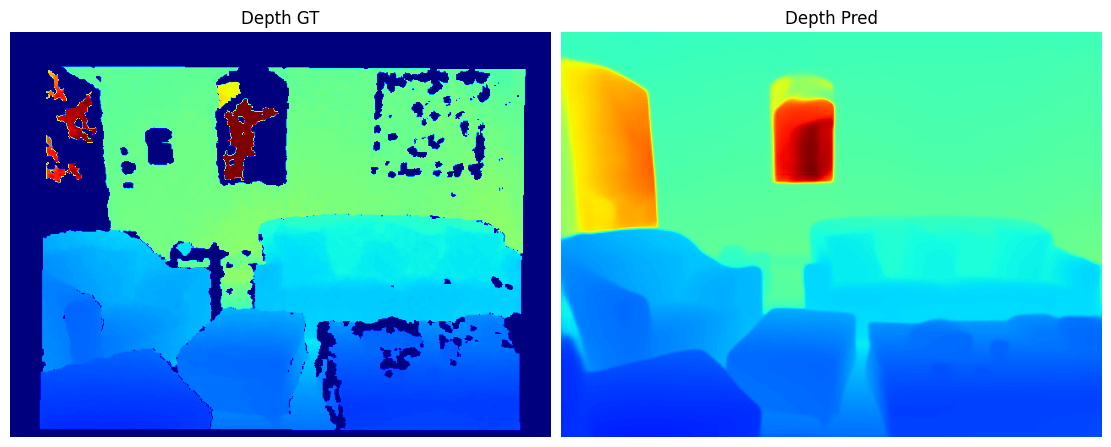

In [13]:
# visualize prediction
fig, axs = plt.subplot_mosaic(
    [['Depth_GT', 'Depth_Pred']], figsize=(11, 11), layout='constrained')

plt_img1 = axs['Depth_GT'].imshow(depth_gt, vmin=0, vmax=10, cmap='jet')
axs['Depth_GT'].set_axis_off()
axs['Depth_GT'].set_title('Depth GT')

plt_img2 = axs['Depth_Pred'].imshow(depth_pred, vmin=0, vmax=10, cmap='jet')
axs['Depth_Pred'].set_axis_off()
axs['Depth_Pred'].set_title('Depth Pred')

plt.show()


In [14]:
# Open3D rgbd image
o3d_color = open3d.geometry.Image(rgb)
o3d_depth = open3d.geometry.Image(depth_pred)
o3d_rgbd = open3d.geometry.RGBDImage.create_from_color_and_depth(
    color=o3d_color,
    depth=o3d_depth,
    depth_scale=1.0,
    depth_trunc=10.0,
    convert_rgb_to_intensity=False
)
# open3d.visualization.draw_geometries([o3d_rgbd])

# point cloud
pcd_pred = open3d.geometry.PointCloud.create_from_rgbd_image(
    image=o3d_rgbd,
    intrinsic=open3d.camera.PinholeCameraIntrinsic(width=width, height=height, intrinsic_matrix=intrinsics_pred),
    project_valid_depth_only=True
)
# open3d.visualization.draw_geometries([pcd_gt])

# difference
np_colors = np.asarray(pcd_pred.colors)
np_colors[:] = np.array([1., 0., 0.])
pcd_pred.colors = open3d.utility.Vector3dVector(np_colors)

np_colors = np.asarray(pcd_gt.colors)
np_colors[:] = np.array([0., 1., 0.])
pcd_gt.colors = open3d.utility.Vector3dVector(np_colors)

open3d.visualization.draw_geometries([pcd_pred, pcd_gt])
